In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from pandas import DataFrame

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [86]:
data = pd.read_csv('winequality-red.csv', sep = ';')

1.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [87]:
y = data.quality
X = data.drop(columns='quality')

learn_df, test_df, learn_y, test_y = train_test_split(X, y, test_size=0.3)


2.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [88]:
tree_classifier_model = DecisionTreeClassifier()
tree_classifier_model.fit(learn_df, learn_y)
tree_classifier_predict = tree_classifier_model.predict(test_df)
tree_accuracy = accuracy_score(test_y, tree_classifier_predict)
print('Accuracy for DecisionTreeClassifier: ', tree_accuracy)

Accuracy for DecisionTreeClassifier:  0.6


In [89]:
bc_with_trees = BaggingClassifier(base_estimator=tree_classifier_model, n_estimators=100)
bc_with_trees.fit(learn_df, learn_y)
bc_with_trees_predict = bc_with_trees.predict(test_df)
bc_with_trees_accuracy = accuracy_score(test_y, bc_with_trees_predict)
print('Accuracy for BaggingClassifier with 100 trees: ', bc_with_trees_accuracy)

Accuracy for BaggingClassifier with 100 trees:  0.66875


In [90]:
def get_random_forest_accuracy_with_n_trees(trees_count:int):
    random_forest_model = RandomForestClassifier(n_estimators=trees_count)
    random_forest_model.fit(learn_df, learn_y)
    random_forest_predict = random_forest_model.predict(test_df)
    random_forest_accuracy = accuracy_score(test_y, random_forest_predict)
    return random_forest_accuracy

random_forest_accuracy = get_random_forest_accuracy_with_n_trees(100)

print('Accuracy for RandomForestClassifier with n_estimators=100: ', random_forest_accuracy)

Accuracy for RandomForestClassifier with n_estimators=100:  0.69375


Вывод: Bagging дает лучшие результаты, чем простое применение DecisionTreeClassifier,
однако RandomForestClassifier, использующий внутри тот же DecisionTreeClassifier дает ещё лучшие результаты

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [91]:
accuracy_by_n = DataFrame(columns=['n_trees', 'accuracy'])

for a in range(1,25):
    current_model = RandomForestClassifier(n_estimators=a*200)
    current_n = a*200
    current_accuracy = get_random_forest_accuracy_with_n_trees(current_n)
    row_df = DataFrame.from_dict({'n_trees': [current_n], 'accuracy': [current_accuracy]})
    accuracy_by_n = pd.concat([accuracy_by_n, row_df])
accuracy_by_n = accuracy_by_n.reset_index(drop=True)
accuracy_by_n = accuracy_by_n.set_index('n_trees')
accuracy_by_n.head()

/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,accuracy
n_trees,
200,0.683333
400,0.685417
600,0.685417
800,0.685417
1000,0.679167


<AxesSubplot:xlabel='n_trees'>

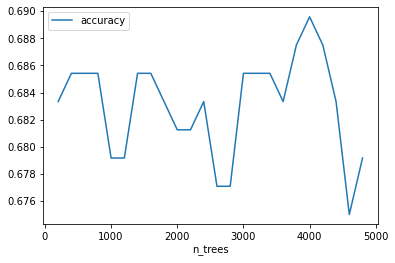

In [92]:
accuracy_by_n.plot()



4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [93]:
sk_learn_gradient_boosting_model = GradientBoostingClassifier()
cross_val_score_sk_gradient_boosting = cross_val_score(sk_learn_gradient_boosting_model, learn_df, learn_y, scoring='accuracy')
print(f'Cross_val_score for gradient boosting sklearn: {cross_val_score_sk_gradient_boosting}')

print(f'xgboost library version {xgboost.__version__}')
xgboost_gradient_boosting_model = xgboost.XGBClassifier()

le = LabelEncoder()
learn_y_labeled = le.fit_transform(learn_y)
test_y_labeled = le.fit_transform(test_y)

cross_val_score_xgboost_gradient_boosting = cross_val_score(xgboost_gradient_boosting_model, learn_df, learn_y_labeled, scoring='accuracy', error_score='raise')
print(f'Cross_val_score for gradient boosting xgboost: {cross_val_score_xgboost_gradient_boosting}')

mean_sklearn = cross_val_score_sk_gradient_boosting.mean()
mean_xgboost = cross_val_score_xgboost_gradient_boosting.mean()

assert mean_xgboost > mean_sklearn

Cross_val_score for gradient boosting sklearn: [0.68303571 0.58928571 0.60267857 0.63839286 0.632287  ]
xgboost library version 1.7.1
Cross_val_score for gradient boosting xgboost: [0.65625    0.65178571 0.60267857 0.64732143 0.65022422]


Вывод: реализация градиентного бустинга с параметрами по умолчанию в xgboost дает лучшие результаты по метрике accuracy по сравнению с реализацией в sklearn

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [94]:
from sklearn.model_selection import GridSearchCV

dict_param_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0,9],
'n_estimators': [1, 10, 25, 50],
'max_depth': range(1,12)}


In [95]:
%%time 

grid_sklearn = GridSearchCV(sk_learn_gradient_boosting_model, cv=3, param_grid=dict_param_grid)

grid_sklearn.fit(learn_df, learn_y)
predicted  = grid_sklearn.predict(test_df)
accuracy = accuracy_score(test_y, predicted)
print(accuracy)
print(grid_sklearn.best_params_)


/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
132 fits failed out of a total of 1056.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
132 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 274, in _chec

0.65625
{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 25}
CPU times: user 4min 8s, sys: 1.63 s, total: 4min 10s
Wall time: 4min 10s


In [96]:
%%time
grid_xgboost = GridSearchCV(xgboost_gradient_boosting_model, cv=3, param_grid=dict_param_grid)

grid_xgboost.fit(learn_df, learn_y_labeled)
predicted  = grid_xgboost.predict(test_df)

accuracy = accuracy_score(test_y_labeled, predicted)
print(accuracy)
print(grid_xgboost.best_params_)


0.6583333333333333
{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 25}
CPU times: user 6min 26s, sys: 3min 26s, total: 9min 53s
Wall time: 1min 46s


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [97]:
l = LGBMClassifier()
l.fit(learn_df, learn_y)
pp = l.predict(test_df)
accuracy_lg = accuracy_score(test_y, pp)
print(f'Accuracy for lightgbm: {accuracy_lg}')

Accuracy for lightgbm: 0.6625


In [98]:
cat = CatBoostClassifier(silent=True)
cat.fit(learn_df, learn_y)
pp_cat = cat.predict(test_df)
accuracy_cat = accuracy_score(test_y, pp_cat)
print(f'Accuracy for catboost: {accuracy_cat}')

Accuracy for catboost: 0.6770833333333334


7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [99]:
grid_lgb = GridSearchCV(l, param_grid=dict_param_grid, cv=3)
grid_lgb.fit(learn_df, learn_y)
predicted = grid_lgb.predict(test_df)
accuracy_grid_lgb = accuracy_score(test_y, predicted)
print(f'Accuracy for grid with lightgbm: {accuracy_grid_lgb}')
print(grid_lgb.best_params_)

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1666917096315/work/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1666917096315/work/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1666917096315/work/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1666917096315/work/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1666917096315/work/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /Users/runner/miniforge3/conda-bld/lightgbm_1666917096315/work/compile/src/io/config_auto.cpp, line 331 .

Accuracy for grid with lightgbm: 0.6333333333333333
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 25}


In [100]:
grid_cat = GridSearchCV(cat, param_grid = dict_param_grid, cv = 3)
grid_cat.fit(learn_df, learn_y)
predicted_cat = grid_cat.predict(test_df)
accuracy_grid_cat = accuracy_score(test_y, predicted_cat)
print(f'Accuracy for grid with catboost: {accuracy_grid_cat}')
print(grid_cat.best_params_)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

Accuracy for grid with catboost: 0.6291666666666667
{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 50}


/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
132 fits failed out of a total of 1056.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
132 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [134]:
from optuna import create_study
import optuna
from optuna.samplers import TPESampler


sampler = TPESampler(multivariate=False)
study = create_study(direction="maximize", sampler=sampler)
def objective(
    trial,
    X,
    y,
    n_splits=3,
    n_repeats=2,
    n_jobs=1,
    early_stopping_rounds=50,
):
    param = {
        'silent':1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 6),
        'n_estimators': trial.suggest_int('n_estimators', 1, 6 ),
    }

    learn_df, test_df, learn_y, test_y = train_test_split(X, y, test_size=0.3)
    f = xgboost_gradient_boosting_model.fit(learn_df, learn_y)
    predicted = f.predict(test_df)
    acs =  accuracy_score(test_y, predicted)
    if acs > 0.9:
        print('Let count this result is pretty good to stop optimization')
        study.stop()
    return acs

In [135]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(
    lambda trial: objective(
        trial,
        X,
        LabelEncoder().fit_transform(y),
        n_jobs=8
    ),
    n_jobs=8,
)

# display params
hp = study.best_params

[I 2022-11-06 23:33:37,871] Trial 2 finished with value: 0.66875 and parameters: {'learning_rate': 0.09988112899715929, 'max_depth': 4, 'n_estimators': 5}. Best is trial 2 with value: 0.66875.
[I 2022-11-06 23:33:38,019] Trial 3 finished with value: 0.65625 and parameters: {'learning_rate': 0.04970099944480152, 'max_depth': 4, 'n_estimators': 4}. Best is trial 2 with value: 0.66875.
[I 2022-11-06 23:33:38,047] Trial 4 finished with value: 0.65 and parameters: {'learning_rate': 0.07421519378014868, 'max_depth': 6, 'n_estimators': 1}. Best is trial 2 with value: 0.66875.
[I 2022-11-06 23:33:38,068] Trial 1 finished with value: 0.69375 and parameters: {'learning_rate': 0.06678227816085888, 'max_depth': 5, 'n_estimators': 2}. Best is trial 1 with value: 0.69375.
[I 2022-11-06 23:33:38,134] Trial 6 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 0.02173189060360423, 'max_depth': 6, 'n_estimators': 2}. Best is trial 1 with value: 0.69375.
[I 2022-11-06 23:33:38,186]

Let count this result is pretty good to stop optimization


[I 2022-11-06 23:33:47,145] Trial 15 finished with value: 0.6645833333333333 and parameters: {'learning_rate': 0.017374400492971273, 'max_depth': 6, 'n_estimators': 2}. Best is trial 8 with value: 0.9020833333333333.
[I 2022-11-06 23:33:47,981] Trial 16 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 0.06458692336801258, 'max_depth': 5, 'n_estimators': 4}. Best is trial 8 with value: 0.9020833333333333.


In [136]:
hp

{'learning_rate': 0.050809293300198344, 'max_depth': 5, 'n_estimators': 4}

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [137]:
from sklearn.ensemble import StackingClassifier


10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.